### Creating rasters of annual inundation metrics using Landsat



### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

from odc.stac import configure_s3_access, load
import matplotlib.pyplot as plt
from pystac_client import Client as PystacClient
import numpy as np
import geopandas as gpd
import odc.geo.xr
import xarray as xr
from pprint import pprint

#from dea_tools.bandindices import calculate_indices
#from dea_tools.dask import create_local_dask_cluster
#from dea_tools.datahandling import load_ard
#from dea_tools.plotting import display_map, xr_animation
from odc.geo.geom import Geometry

from IPython.display import Image
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

In [2]:
from eo_insights.stac_configuration import de_australia_stac_config
from eo_insights.raster_base import RasterBase, QueryParams, LoadParams
from odc.algo import erase_bad, mask_cleanup

In [3]:
import pandas as pd

### Connect to the datacube

Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [4]:
catalog = "https://explorer.dea.ga.gov.au/stac"

stac_client = PystacClient.open(catalog)

configure_s3_access(
    cloud_defaults=True,
    aws_unsigned=True,
)

## Set up a Dask cluster

Dask can be used to better manage memory use and conduct the analysis in parallel. 
For an introduction to using Dask with Digital Earth Australia, see the [Dask notebook](../Beginners_guide/09_Parallel_processing_with_Dask.ipynb).

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in JupyterLab* section of the [Dask notebook](../Beginners_guide/09_Parallel_processing_with_Dask.ipynb).

To activate Dask, set up the local computing cluster using the cell below.

In [5]:
from dask.distributed import Client as DaskClient

dask_client = DaskClient()
dask_client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 15.62 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41887,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 15.62 GiB
Comm: tcp://127.0.0.1:45675,Total threads: 1
Dashboard: http://127.0.0.1:44285/status,Memory: 3.90 GiB
Nanny: tcp://127.0.0.1:35477,


## Load cloud-masked satellite data

The code below will create a query dictionary for our region of interest, and then load Sentinel-2 satellite data.
For more information on loading data, see the [Loading data notebook](../Beginners_guide/04_Loading_data.ipynb).

In [6]:
date_query = ['1990-07','1991-06']

collections_query = ['ga_ls5t_ard_3']


In [7]:
items = stac_client.search(
    collections = collections_query,
    bbox= [145.910476061,-29.153361653,148.745019431,-30.128112653],
    datetime = date_query,    
).item_collection()

print(f"Found {len(items)} items")


#bbox south [145.910476061,-29.153361653,148.745019431,-30.128112653]
#bbox north [146.963236949,-27.723499515,148.806899103,-29.169637680]

Found 175 items


In [8]:
ds = load(
    items,
    bands=['nbart_red', 'nbart_green', 'nbart_nir',
                     'nbart_swir_1', 'nbart_swir_2', 'oa_fmask'],
    crs="utm",
    chunks={"time": -1, "x": 400, "y": 400},
    resolution=30,
    groupby="solar_day",
    bbox= [145.910476061,-29.153361653,148.745019431,-30.128112653],
)


ds

<xarray.Dataset> Size: 70GB
Dimensions:       (y: 3627, x: 9191, time: 88)
Coordinates:
  * y             (y) float64 29kB 6.775e+06 6.774e+06 ... 6.666e+06 6.666e+06
  * x             (x) float64 74kB 3.94e+05 3.941e+05 ... 6.697e+05 6.697e+05
    spatial_ref   int32 4B 32755
  * time          (time) datetime64[ns] 704B 1990-07-04T23:33:33.248081 ... 1...
Data variables:
    nbart_red     (time, y, x) float32 12GB dask.array<chunksize=(88, 400, 400), meta=np.ndarray>
    nbart_green   (time, y, x) float32 12GB dask.array<chunksize=(88, 400, 400), meta=np.ndarray>
    nbart_nir     (time, y, x) float32 12GB dask.array<chunksize=(88, 400, 400), meta=np.ndarray>
    nbart_swir_1  (time, y, x) float32 12GB dask.array<chunksize=(88, 400, 400), meta=np.ndarray>
    nbart_swir_2  (time, y, x) float32 12GB dask.array<chunksize=(88, 400, 400), meta=np.ndarray>
    oa_fmask      (time, y, x) float32 12GB dask.array<chunksize=(88, 400, 400), meta=np.ndarray>

In [9]:
mask_bitfields = [1,5]  
bitmask = 0
for field in mask_bitfields:
    bitmask |= 1 << field

# Get cloud mask
cloud_mask = ds["oa_fmask"].astype(int) & bitmask != 0

#cloud_mask = mask_cleanup(cloud_mask, [("opening", 2), ("dilation", 3)])

ds_masked = ds.where(~cloud_mask)


ds_masked

<xarray.Dataset> Size: 70GB
Dimensions:       (time: 88, y: 3627, x: 9191)
Coordinates:
  * y             (y) float64 29kB 6.775e+06 6.774e+06 ... 6.666e+06 6.666e+06
  * x             (x) float64 74kB 3.94e+05 3.941e+05 ... 6.697e+05 6.697e+05
    spatial_ref   int32 4B 32755
  * time          (time) datetime64[ns] 704B 1990-07-04T23:33:33.248081 ... 1...
Data variables:
    nbart_red     (time, y, x) float32 12GB dask.array<chunksize=(88, 400, 400), meta=np.ndarray>
    nbart_green   (time, y, x) float32 12GB dask.array<chunksize=(88, 400, 400), meta=np.ndarray>
    nbart_nir     (time, y, x) float32 12GB dask.array<chunksize=(88, 400, 400), meta=np.ndarray>
    nbart_swir_1  (time, y, x) float32 12GB dask.array<chunksize=(88, 400, 400), meta=np.ndarray>
    nbart_swir_2  (time, y, x) float32 12GB dask.array<chunksize=(88, 400, 400), meta=np.ndarray>
    oa_fmask      (time, y, x) float32 12GB dask.array<chunksize=(88, 400, 400), meta=np.ndarray>

## Calculate the Fisher water index, binarise water and edit date type

IMPORTANT: change the reference date accordingly

In [10]:
# Calculate the chosen vegetation proxy index and add it to the loaded data set
ds_masked['fwi'] = 1.7204 + 171*(ds_masked.nbart_green/10000) + 3*(ds_masked.nbart_red/10000) - 70*(ds_masked.nbart_nir/10000) - 45*(ds_masked.nbart_swir_1/10000)-71*(ds_masked.nbart_swir_2/10000)

#Binarise water
X_bin = ds_masked['fwi'] >= -10.63

X_bin = X_bin.where(np.isnan(ds_masked['fwi'])==False, np.nan)

ds_masked['water'] = X_bin


# Define the reference period (start date)
reference_date = np.datetime64('1990-07-01')

# Transform date values to the number of days since the reference period
days_since_reference = (ds_masked.time.values - reference_date).astype('timedelta64[D]').astype(int)

ds_masked.coords["time"] = days_since_reference

ds_masked

<xarray.Dataset> Size: 106GB
Dimensions:       (time: 88, y: 3627, x: 9191)
Coordinates:
  * y             (y) float64 29kB 6.775e+06 6.774e+06 ... 6.666e+06 6.666e+06
  * x             (x) float64 74kB 3.94e+05 3.941e+05 ... 6.697e+05 6.697e+05
    spatial_ref   int32 4B 32755
  * time          (time) int64 704B 3 5 12 14 19 21 ... 341 348 350 355 357 364
Data variables:
    nbart_red     (time, y, x) float32 12GB dask.array<chunksize=(88, 400, 400), meta=np.ndarray>
    nbart_green   (time, y, x) float32 12GB dask.array<chunksize=(88, 400, 400), meta=np.ndarray>
    nbart_nir     (time, y, x) float32 12GB dask.array<chunksize=(88, 400, 400), meta=np.ndarray>
    nbart_swir_1  (time, y, x) float32 12GB dask.array<chunksize=(88, 400, 400), meta=np.ndarray>
    nbart_swir_2  (time, y, x) float32 12GB dask.array<chunksize=(88, 400, 400), meta=np.ndarray>
    oa_fmask      (time, y, x) float32 12GB dask.array<chunksize=(88, 400, 400), meta=np.ndarray>
    fwi           (time, y, x) float32 12GB dask.array<chunksize=(88, 400, 400), meta=np.ndarray>
    water         (time, y, x) float64 23GB dask.array<chunksize=(88, 400, 400), meta=np.ndarray>

In [11]:
ds_masked = ds_masked.isel(y=slice(2000,2400),x=slice(3500,3900))

/home/vscode/.local/lib/python3.11/site-packages/dask/array/chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/home/vscode/.local/lib/python3.11/site-packages/dask/array/chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/home/vscode/.local/lib/python3.11/site-packages/dask/array/chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)


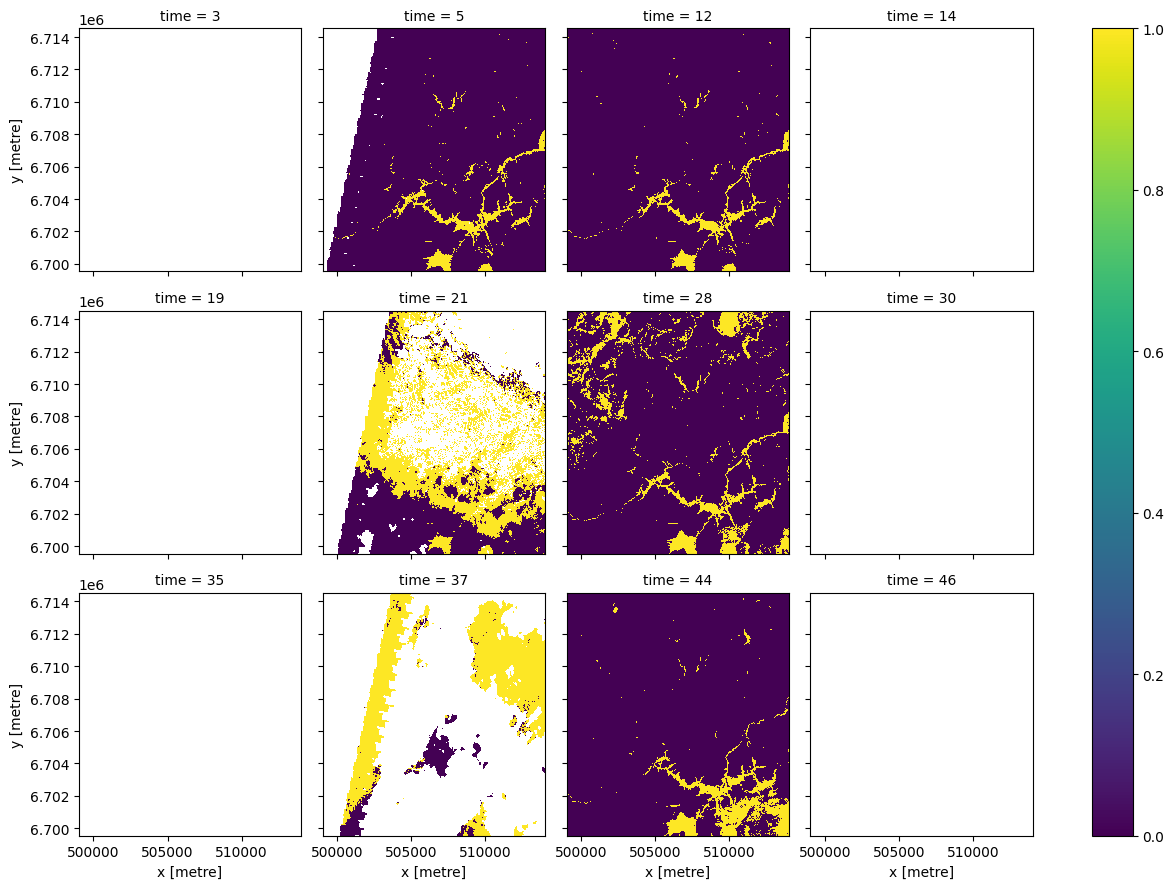

In [ ]:
ds_masked[["water"]].isel(time=slice(0, 12),y=slice(2000,2500),x=slice(3500,4000)).to_array().plot(
    col="time", col_wrap=4)

In [25]:
diff = np.diff(np.append(np.zeros(np.shape(arr[1:2])), arr, axis=0), axis = 0)
starts = np.where(diff == 1)[0] + 1
ends = np.where(diff == -1)[0] + 1

if arr[0]:
        starts = np.insert(starts, 0, 0)
if arr[-1]:
        ends = np.append(ends, len(diff))

if len(starts) == 0 or len(ends) == 0:
    return 0  # Return default value if there are no valid starts or ends

lengths = ends - starts


if len(starts) == 0 or len(ends) == 0:
        return 0  # Return default value if there are no valid starts or ends

max_len = np.max(lengths)
idx = np.argmax(lengths)

/home/vscode/.local/lib/python3.11/site-packages/dask/array/chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/home/vscode/.local/lib/python3.11/site-packages/dask/array/chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/home/vscode/.local/lib/python3.11/site-packages/dask/array/chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/home/vscode/.local/lib/python3.11/site-packages/dask/array/chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [32]:
np.shape(ends)

(83309,)

### Functions to obtain longest inundation period and date of start. 

Creates 2 arrays which we then combine into a dataset to write into a tiff

In [33]:
def time_difference_slice(arr, times):
    diff = np.diff(np.append(np.zeros(np.shape(arr[1:2])), arr, axis=0), axis = 0)
    starts = np.where(diff == 1)[0] + 1
    ends = np.where(diff == -1)[0] + 1

    print(np.shape(starts))
    print(np.shape(ends))


    if arr[0]:
        starts = np.insert(starts, 0, 0)
    if arr[-1]:
        ends = np.append(ends, len(diff))

    print(np.shape(starts))
    print(np.shape(ends))

    
    if len(starts) == 0 or len(ends) == 0:
        return 0  # Return default value if there are no valid starts or ends

    lengths = ends - starts
    if lengths.size == 0:
        return 0  # Return default value if no consecutive 1s are found

    max_len = np.max(lengths)
    idx = np.argmax(lengths)
    
    start_idx = starts[idx]
    end_idx = ends[idx] - 1

    start_time = times[start_idx]
    end_time = times[end_idx]

    if (end_time + 1) > start_time:
        time_difference = (end_time + 1) - start_time
    else:
        time_difference = 0
    

    return time_difference

def start_time_slice(arr, times):
    diff = np.diff(np.append(np.zeros(np.shape(arr[1:2])), arr, axis=0), axis = 0)
    starts = np.where(diff == 1)[0] + 1
    ends = np.where(diff == -1)[0] + 1

    if arr[0]:
        starts = np.insert(starts, 0, 0)
    if arr[-1]:
        ends = np.append(ends, len(diff))

    if len(starts) == 0 or len(ends) == 0:
        return np.nan  # Return default value if there are no valid starts or ends

    lengths = ends - starts
    if lengths.size == 0:
        return np.nan  # Return default value if no consecutive 1s are found

    idx = np.argmax(lengths)
    start_idx = starts[idx]

    end_idx = ends[idx] - 1

    start_time = times[start_idx]
    end_time = times[end_idx]    

    if end_time > start_time:
        start_time = times[start_idx]
    else:
        start_time = np.nan

        
    return start_time

length_array = xr.apply_ufunc(
    time_difference_slice,
    ds_masked.water,
    ds_masked.time,
    input_core_dims=[['time'], ['time']],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float]
)

start_time_array = xr.apply_ufunc(
    start_time_slice,
    ds_masked.water,
    ds_masked.time,
    input_core_dims=[['time'], ['time']],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float]
)


dsyearlywaterdyn = xr.Dataset(
    {
        "length": (["y", "x"], length_array.data),
        "start_time": (["y", "x"], start_time_array.data),
    },
    coords={"x": ds_masked.water.x, "y": ds_masked.water.y}
) 

### Write the dataset into a tiff file. 

Output will save in DEA Sandbox directory from where it can be downloaded

In [34]:
%%time


dsyearlywaterdyn_array = dsyearlywaterdyn.to_array()


file = dsyearlywaterdyn_array.odc.write_cog(fname='LBsouthtest_annual_watermetrics_9091.tif',
          overwrite=True)


file

/home/vscode/.local/lib/python3.11/site-packages/dask/array/chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/home/vscode/.local/lib/python3.11/site-packages/dask/array/chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)


(0,)
(2,)
(1,)
(3,)
(1,)
(1,)
(2,)
(2,)
(1,)
(1,)
(2,)
(2,)
(1,)
(1,)
(2,)
(2,)
(1,)
(1,)
(2,)
(2,)
(1,)
(1,)
(2,)
(2,)
(1,)
(0,)
(2,)
(1,)
(1,)
(0,)
(2,)
(1,)
(1,)
(0,)
(2,)
(1,)
(1,)
(0,)
(2,)
(1,)
(1,)
(0,)
(2,)
(1,)
(1,)
(0,)
(2,)
(1,)
(1,)
(0,)
(2,)
(1,)
(1,)
(0,)
(2,)
(1,)
(1,)
(0,)
(2,)
(1,)
(1,)
(0,)
(2,)
(1,)
(1,)
(0,)
(2,)
(1,)
(1,)
(0,)
(2,)
(1,)
(1,)
(0,)
(2,)
(1,)
(1,)
(0,)
(2,)
(1,)
(1,)
(0,)
(2,)
(1,)
(1,)
(0,)
(2,)
(1,)
(1,)
(0,)
(2,)
(1,)
(1,)
(0,)
(2,)
(1,)
(1,)
(0,)
(2,)
(1,)
(1,)
(0,)
(2,)
(1,)
(1,)
(0,)
(2,)
(1,)
(1,)
(0,)
(2,)
(1,)
(1,)
(0,)
(2,)
(1,)
(1,)
(0,)
(2,)
(1,)
(1,)
(0,)
(2,)
(1,)
(1,)
(0,)
(2,)
(1,)
(1,)
(0,)
(2,)
(1,)
(1,)
(0,)
(2,)
(1,)
(0,)
(0,)
(1,)
(1,)
(0,)
(0,)
(1,)
(1,)
(0,)
(0,)
(1,)
(1,)
(0,)
(0,)
(1,)
(1,)
(0,)
(0,)
(1,)
(1,)
(0,)
(0,)
(1,)
(1,)
(0,)
(0,)
(1,)
(1,)
(0,)
(0,)
(1,)
(1,)
(0,)
(0,)
(1,)
(1,)
(0,)
(0,)
(1,)
(1,)
(0,)
(0,)
(1,)
(1,)
(0,)
(0,)
(1,)
(1,)
(0,)
(0,)
(1,)
(1,)
(0,)
(0,)
(1,)
(1,)
(0,)
(0,)
(1,)
(1,)
(0,)
(0,)
(1,)
(1,)


2025-04-14 02:07:33,251 - distributed.worker - ERROR - Compute Failed
Key:       ('transpose-vectorize_time_difference_slice-vectorize_time_difference_slice_0-stack-a1ecad14bf2b81100b5e8359c5c1891a', 0, 0, 0)
State:     executing
Task:  <Task ('transpose-vectorize_time_difference_slice-vectorize_time_difference_slice_0-stack-a1ecad14bf2b81100b5e8359c5c1891a', 0, 0, 0) _execute_subgraph(...)>
Exception: "IndexError('index 2 is out of bounds for axis 0 with size 1')"
Traceback: '  File "/home/vscode/.local/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py", line 2522, in __call__\n    return self._call_as_normal(*args, **kwargs)\n           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/home/vscode/.local/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py", line 2515, in _call_as_normal\n    return self._vectorize_call(func=func, args=vargs)\n           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/home/vscode/.local/lib/python3.11/site-packages/numpy/lib/

IndexError: index 2 is out of bounds for axis 0 with size 1

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Discord chat](https://discord.com/invite/4hhBQVas5U) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).

If you would like to report an issue with this notebook, you can file one on [GitHub](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** July 2024

**Compatible datacube version:**

In [ ]:
print(datacube.__version__)

1.8.18
